# Consumer Opt. with PV

In [1]:
using Pkg
Pkg.activate("."); 
Pkg.instantiate()

  Activating project at `C:\Users\ESchr\workspace\uni\ATIS3\Single_Project\ATIES3_single_project_ES`


In [2]:
using JuMP, LinearAlgebra, StatsPlots, Statistics, CSV, DataFrames, XLSX, CPLEX, AxisArrays, Plots, StatsBase, JLD2, FileIO

## Input handling

In [3]:
data = Dict()
input_path = "input\\"
xl1 = XLSX.readxlsx(input_path * "input.xlsx") 
xl2 = XLSX.readxlsx(input_path * "solar_input.xlsx") 
xl3 = XLSX.readxlsx(input_path * "prices.xlsx") 


for s in XLSX.sheetnames(xl1)
    data[s] = DataFrame(XLSX.gettable(xl1[s]; infer_eltypes=true)...)
end

for s in XLSX.sheetnames(xl2)
    data[s] = DataFrame(XLSX.gettable(xl2[s]; infer_eltypes=true)...)
end

for s in XLSX.sheetnames(xl3)
    data[s] = DataFrame(XLSX.gettable(xl3[s]; infer_eltypes=true)...)
end

# Data handling

In [4]:
#create sets
T = data["solar_input"][:, :Time]
FC_S = data["solar_input"][:, :FC_Solar]
Act_S = data["solar_input"][:, :Act_Solar]
H = data["prices"][:, :Hour]
TIME = data["prices"][:, :Time]
DHP = data["prices"][:, :Day_Ahead_Price]
T_NQ = length(T)

#create eight-hour sets
morning = [1, 2, 3, 4, 5, 6, 7, 8]
noon = [9, 10, 11, 12, 13, 14, 15, 16]
evening = [17, 18, 19, 20, 21, 22,23, 0]

#axial array transformation
Dsolar_input = Dict(c => AxisArray(data["solar_input"][:, c], t = 1:T_NQ) for c in names(data["solar_input"]));
Dprice = Dict(c => AxisArray(data["prices"][:, c], h = H) for c in names(data["prices"]));
println("Sets created")

Sets created


In [5]:
#combine price and solar data with hour dependcy
h = 1
i = 1
FC_Solar = 0
Act_Solar = 0
Day_Ahead_Price = 0
Data = Dict()

#compute hourly PV production values
for t in 1:T_NQ
    FC_Solar += Dsolar_input["FC_Solar"][t]
    Act_Solar += Dsolar_input["Act_Solar"][t]
    if(h == 4)
        if(Dprice["Hour"][i] in morning)            
            PV_Data = Dict("FC_Solar" => round((FC_Solar/4), digits = 2), "Act_Solar" => round((Act_Solar/4), digits = 2), "price" => Dprice["Day_Ahead_Price"][i], "hour" => Dprice["Hour"][i], "set" => 1)
        elseif(Dprice["Hour"][i] in noon) 
            PV_Data = Dict("FC_Solar" => round((FC_Solar/4), digits = 2), "Act_Solar" => round((Act_Solar/4), digits = 2), "price" => Dprice["Day_Ahead_Price"][i], "hour" => Dprice["Hour"][i], "set" => 2)
        elseif(Dprice["Hour"][i] in evening) 
            PV_Data = Dict("FC_Solar" => round((FC_Solar/4), digits = 2), "Act_Solar" => round((Act_Solar/4), digits = 2), "price" => Dprice["Day_Ahead_Price"][i], "hour" => Dprice["Hour"][i], "set" => 3)
        end
        Data[i] = PV_Data
        h = 0
        i += 1
        FC_Solar = 0
        Act_Solar = 0
    end
    h += 1
end

In [6]:
#Sets
#W_PP = data["pool_price_scenarios"][:, :Scenario]
W_NAM = data["non_anticipativity_matrix"][:, :Scenario]
B = data["bilateral_contract_data"][:, :Contract]
D = data["electricity_demand"][:, :Demand]
WEEK = ["we1", "we2", "we3", "we4"]
K = ["k1", "k2", "k3", "k4"]

#create scenario set
Ω = String[]
for t in 1:48
    n = string("w", t)
    push!(Ω, n)
end
W_PP = Ω

T = String[]
for c in names(data["pool_price_scenarios"])
    push!(T, c)
end
T = T[2:end]

#Axis arrays
Dbilateral_contract_data = Dict(c => AxisArray(data["bilateral_contract_data"][:, c], b=B) for c in names(data["bilateral_contract_data"]));
Delectricity_demand = Dict(c => AxisArray(data["electricity_demand"][:, c], d=D) for c in names(data["electricity_demand"]));
Dnon_anticipativity_matrix = Dict(c => AxisArray(data["non_anticipativity_matrix"][:, c], w_nam=W_NAM) for c in names(data["non_anticipativity_matrix"]));

#Mapping of bilateral contracts active in period T
Bt = Dict()
for week in WEEK
    temp = String[]
    for b in B
        if(Dbilateral_contract_data[week][b]==1)
            push!(temp, b)
        end
    end
    Bt[week] = temp
end 

#Mapping of decisions on bilateral contracts made in stage K
Kb = Dict()
Kb["k1"] = Bt["we1"]
Kb["k2"] = ["b7", "b8"]
Kb["k3"] = ["b9", "b10"]
Kb["k4"] = ["b12", "b11"]

#Arrays of decisions on bilateral contracts made in stage K
k1 = data["non_anticipativity_matrix"][:, :k1]
k2 = data["non_anticipativity_matrix"][:, :k2]
k3 = data["non_anticipativity_matrix"][:, :k3]
k4 = data["non_anticipativity_matrix"][:, :k4]

NW_PP = length(W_PP)

#week hour allocation 
week_to_hour = Dict()
week_to_hour["we1"] = T[1:21]
week_to_hour["we2"] = T[22:42]
week_to_hour["we3"] = T[43:63]
week_to_hour["we4"] = T[64:end]
println("Sets created")

Sets created


# Scenario Generation

## Spring price scenarios
Scenarios are calculated through the different hour blocks. Therefore there exists no direct connection between two sequential hourly periods, as we consider the scenario as an average value for the hours. In Germany spring begins on March 21, summer begins on June 21, autumn begins on September 23, and winter begins on December 21. 

In [7]:
#spring starts at hour 1896 and ends at 4104
D_spring_price =  Dict()
spring_price = Float64[]
spring_act_solar = Float64[]

D_spring_price1 =  Dict()
spring_price1 = Float64[]
spring_act_solar1 = Float64[]
spring_time1 = Int[]

D_spring_price2 =  Dict()
spring_price2 = Float64[]
spring_act_solar2 = Float64[]
spring_time2 = Int[]

D_spring_price3 =  Dict()
spring_price3 = Float64[]
spring_act_solar3 = Float64[]
spring_time3 = Int[]

#create dict for price and solar values according to the destinction between morning, noon, evening
for t in TIME[1896:4104]
    D_spring_price[t] = Data[t]
    push!(spring_price, Data[t]["price"])
    push!(spring_act_solar, Data[t]["Act_Solar"])    
    if(Data[t]["set"]==1)
        D_spring_price1[t] = Data[t]
        push!(spring_price1, Data[t]["price"])
        push!(spring_act_solar1, Data[t]["Act_Solar"])
        push!(spring_time1, t)
    elseif(Data[t]["set"]==2)
        D_spring_price2[t] = Data[t]
        push!(spring_price2, Data[t]["price"])
        push!(spring_act_solar2, Data[t]["Act_Solar"])
        push!(spring_time2, t)
    elseif(Data[t]["set"]==3)
        D_spring_price3[t] = Data[t]
        push!(spring_price3, Data[t]["price"])
        push!(spring_act_solar3, Data[t]["Act_Solar"])
        push!(spring_time3, t)
    end    
end

## Visualisation Spring

In [8]:
path = raw"C:\Users\ ESchr\ workspace\ uni\ ATIS3\ Single_Project\ ATIES3_single_project_ES\ Plots\plot_ref"

"C:\\Users\\ ESchr\\ workspace\\ uni\\ ATIS3\\ Single_Project\\ ATIES3_single_project_ES\\ Plots\\plot_ref"

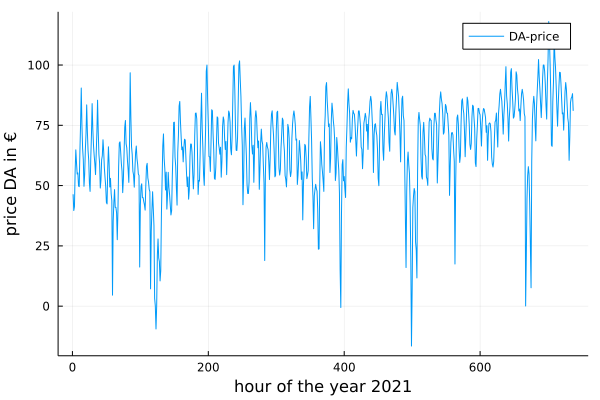

In [9]:
plot_ref = plot(spring_price3,x=:time, y=:price, label = "DA-price")
xlabel!("hour of the year 2021")
ylabel!("price DA in €")
#savefig("DA_price_yearly_h")

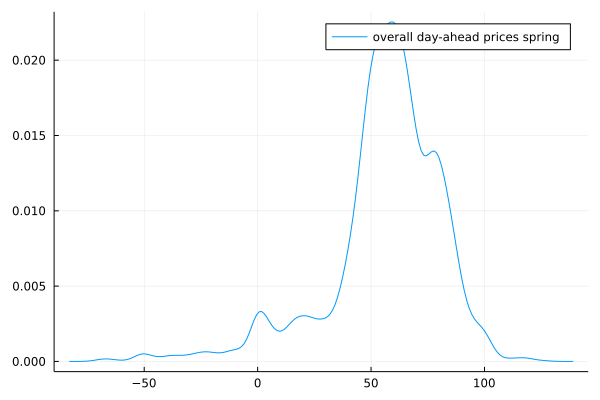

In [10]:
density(spring_price, label="overall day-ahead prices spring")

### Spring morning

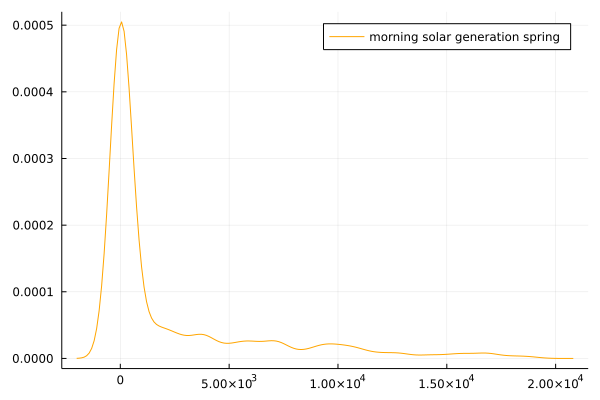

In [11]:
density(spring_act_solar1, label="morning solar generation spring", color= :orange)

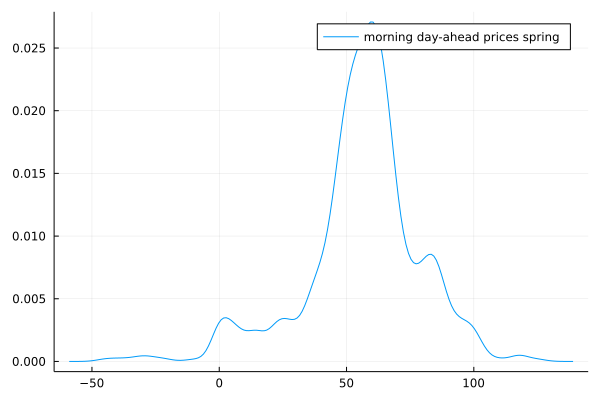

In [12]:
density(spring_price1, label="morning day-ahead prices spring")

### Spring noon

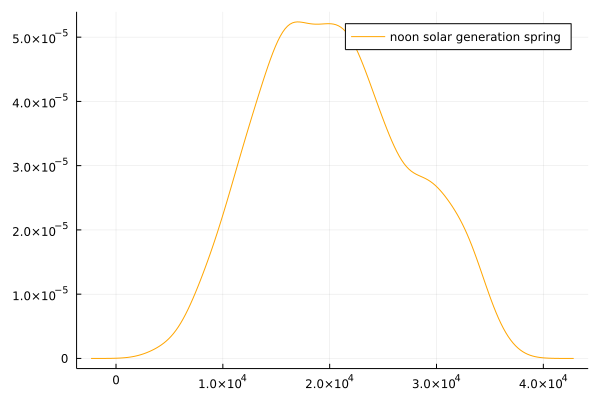

In [13]:
density(spring_act_solar2, label="noon solar generation spring", color= :orange)

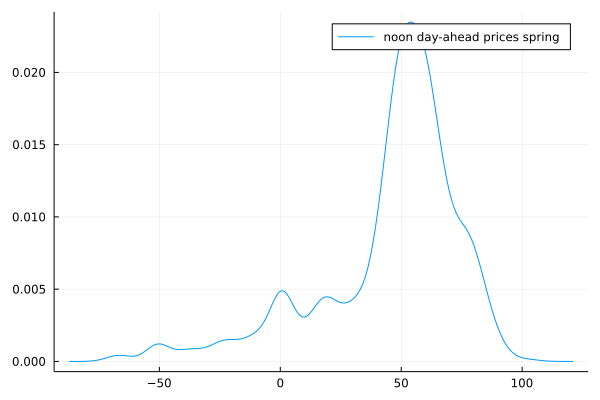

In [14]:
density(spring_price2, label=" noon day-ahead prices spring")

### Spring evening

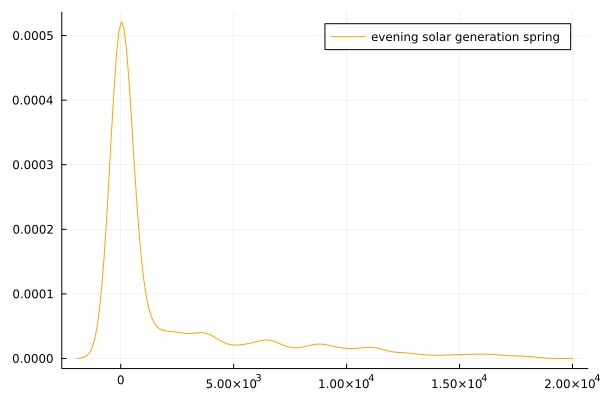

In [15]:
density(spring_act_solar3, label="evening solar generation spring", color= :orange)

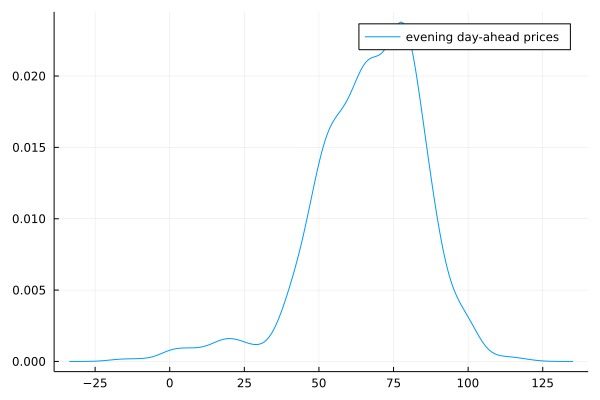

In [16]:
density(spring_price3, label="evening day-ahead prices")

## Scenario Creation
Generate a tree structure with a 4×3×2×2 scenario structure, i.e., from the root node 5 branches leave, from each second-stage
node 4 branches leave, and so on. Attention!, due to the sample based approach each each run generates new, different scenarios. 

In [17]:
#create scenario array
Ω = String[]
for t in 1:48
    n = string("w", t)
    push!(Ω, n)
end

#take sample from price distribution
v_s = sample(spring_time1, 616, replace = false)
s_s = sample(spring_time2, 616, replace = false)
p_s = sample(spring_time3, 616, replace = false)
print("Sample created")

Sample created

### Sample Density vs Overall Density

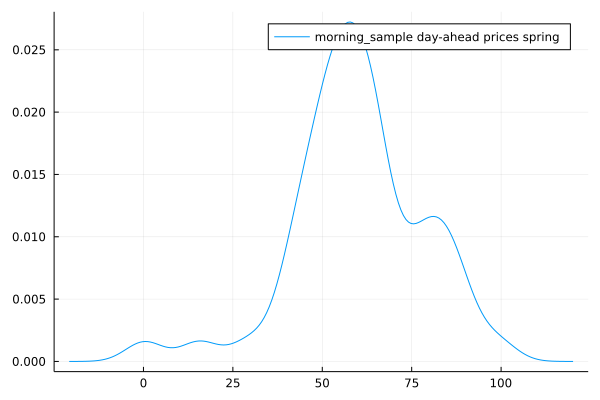

In [18]:
v_s_price = Float64[]
for t in 1:48
    push!(v_s_price, D_spring_price[v_s[t]]["price"])
end
density(v_s_price, label="morning_sample day-ahead prices spring")
#savefig("morning_sample_DA_price_spring")

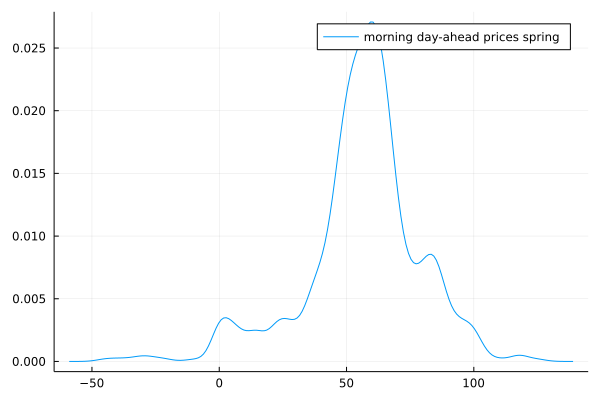

In [19]:
density(spring_price1, label="morning day-ahead prices spring")
#savefig("morning_DA_price_spring")

### Scenario Tree Generation

In [20]:
#creates scenario tree
price_scenarios_spring = DataFrame()
pv_production_scenarios_spring = DataFrame()
t_aux = 1

for k in K
    #for each stage the tree structure gets initialised
    if(k=="k1")
        s = 4
        Range = week_to_hour["we1"]
    elseif(k=="k2")
        s = 12
        Range = week_to_hour["we2"]
    elseif(k=="k3")
        s = 24
        Range = week_to_hour["we3"]
    elseif(k=="k4")
        s = 48
        Range = week_to_hour["we4"]
    end
        
    for t in Range
        p_t = Float64[]
        pv_t = Float64[]
        v_p = 0
        t_ω = 0
        temp = Dict()
        #check which period is considerd
        if(t_aux==1)
            temp = D_spring_price[pop!(v_s)]
            v_p = temp["price"]
            v_pv = temp["Act_Solar"]
        elseif(t_aux==2)
            temp = D_spring_price[pop!(s_s)]
            v_p = temp["price"]
            v_pv = temp["Act_Solar"]
        elseif(t_aux==3)
            temp = D_spring_price[pop!(p_s)]
            v_p = temp["price"]
            v_pv = temp["Act_Solar"]
        end           
        for ω in Ω            
            max_r = length(Ω)/s   
            #check if scenario is in node
            if(t_ω < max_r)                
                push!(p_t, v_p)
                push!(pv_t, ((v_pv/360)*8))
            else
                #if new node is considerd
                if(t_aux==1)
                    temp = D_spring_price[pop!(v_s)]
                    v_p = temp["price"]
                    v_pv = temp["Act_Solar"]
                elseif(t_aux==2)
                    temp = D_spring_price[pop!(s_s)]
                    v_p = temp["price"]
                    v_pv = temp["Act_Solar"]
                elseif(t_aux==3)
                    temp = D_spring_price[pop!(p_s)]
                    v_p = temp["price"]
                    v_pv = temp["Act_Solar"]
                end  
                push!(p_t, v_p)
                push!(pv_t, ((v_pv/360)*8))
                t_ω = 0
            end
            t_ω += 1
        end
        if(!(t_aux==3))
            t_aux += 1
        else
            t_aux = 1
        end
        price_scenarios_spring[!, t] = p_t  
        pv_production_scenarios_spring[!, t] = pv_t
    end
end

#create AxisArrays
cols = T
Dpv_production_scenarios_spring = Dict(c => AxisArray(pv_production_scenarios_spring[:, c], w = Ω) for c in cols);
Dprice_scenarios_spring = Dict(c => AxisArray(price_scenarios_spring[:, c], w = Ω) for c in cols);

In [21]:
#save("Dprice_scenarios_spring.jld2", "data", Dprice_scenarios_spring)
#save("Dpv_production_scenarios_spring.jld2", "data", Dpv_production_scenarios_spring)

### Scenario Tree Visualisation

In [22]:
Dpool_price_scenarios = load("Dprice_scenarios_spring.jld2")["data"]
Dpv_production = load("Dpv_production_scenarios_spring.jld2")["data"]

sce_price_w1 = Float64[]
sce_pv_w1 = Float64[]
for t in T
    push!(sce_pv_w1, (Dpv_production[t]["w1"]))
    push!(sce_price_w1, (Dpool_price_scenarios[t]["w1"]))
end

In [23]:
plot_ref = plot(sce_price_w1, x=:time, y=:price, label = "DA-price")
xlabel!("hour of the year 2021")
ylabel!("price DA in €")
savefig("DA_price_sc_spring")

In [24]:
plot_ref = plot(sce_pv_w1, x=:time, y=:price, label = "PV-production spring", color= :orange)
xlabel!("hour of the year 2021")
ylabel!("PV-production MW")
savefig("PV_production_sc_spring")

# Model

In [25]:
#save particular scenario
#save("Dprice_scenarios_spring.jld2", "data", Dprice_scenarios_spring)
#save("Dpv_production_scenarios_spring.jld2", "data", Dpv_production_scenarios_spring)

In [26]:
#Initialise model  with scenarios
W_PP = Ω

#Probalitie for scenarios
prob = Dict()
for w in W_PP
    prob[w] = 1/length(W_PP)
end

# Risk
β = 5
α = 0.95

#Duration in hours of every period t
d = Dict()
for t in T
    d[t]=1
end

In [27]:
co_pv = Model(CPLEX.Optimizer)

@variables(co_pv, begin
        PB[B,W_PP]            #Power purchased from bilateral contracts
        s[B,W_PP], Bin        #Selection of bilateral contracts
        EP[T,W_PP]            #Energy traded in the pool
        η[W_PP] >= 0          #Auxiliary variable used to calculate the CVaR
        ζ                     #Auxiliary variable used to calculate the CVaR
    end)
   
λ_B = @expression(co_pv, [week in WEEK, t in week_to_hour[week], w in W_PP, b in Bt[week]], (Dpool_price_scenarios[t][w]+Dbilateral_contract_data["price"][b])/2)
λ_P = @expression(co_pv, [t in T, w in W_PP], Dpool_price_scenarios[t][w])     
CVaR = @expression(co_pv, β * (ζ+(1/(1-α))*sum(prob[w]*η[w] for w in W_PP)))  
z = @expression(co_pv, sum(prob[w] * sum(sum(sum(λ_B[week, t, w, b] * PB[b,w] * d[t] for b in Bt[week]) + λ_P[t,w] * EP[t,w] for t in  week_to_hour[week]) for week in WEEK) for w in W_PP) + CVaR)

@constraints(co_pv, begin
        LimitContractMin[b in B, w in W_PP], PB[b,w] >= s[b,w] * (Dbilateral_contract_data["min_power"][b] * 8)
        LimitContractMax[b in B, w in W_PP], PB[b,w] <= s[b,w] * (Dbilateral_contract_data["max_power"][b] * 8)
        
        Non_Anticipativity1[b in Kb["k1"], τ in (1:NW_PP-1)[k1.== 1]], PB[b,W_PP[τ]] == PB[b, W_PP[τ+1]]
        Non_Anticipativity2[b in Kb["k2"], τ in (1:NW_PP-1)[k2.== 1]], PB[b,W_PP[τ]] == PB[b, W_PP[τ+1]]
        Non_Anticipativity3[b in Kb["k3"], τ in (1:NW_PP-1)[k3.== 1]], PB[b,W_PP[τ]] == PB[b, W_PP[τ+1]]
        Non_Anticipativity4[b in Kb["k4"], τ in (1:NW_PP-1)[k4.== 1]], PB[b,W_PP[τ]] == PB[b, W_PP[τ+1]]
        
        Arbitrage[t in T, w in W_PP], EP[t,w] >= -Dpv_production[t][w]
        EnergyBalance[week in WEEK, t in week_to_hour[week], w in W_PP], EP[t,w] + Dpv_production[t][w] + sum(PB[b,w]*d[t] for b in Bt[week]) == Delectricity_demand[t]["d1"]
        CVaRconstr[w in W_PP], sum(sum(sum(λ_B[week, t, w, b] * PB[b,w] * d[t] for b in Bt[week]) + λ_P[t,w] * EP[t,w] for t in  week_to_hour[week]) for week in WEEK) - ζ <= η[w]
        NonNeg[w in W_PP], 0 <= η[w]        
    end)

@objective(co_pv, Min, z)
println("Model created")

Model created


In [28]:
@time begin
    optimize!(co_pv)
end

Version identifier: 20.1.0.0 | 2020-11-10 | 9bedb6d68
Tried aggregator 2 times.
MIP Presolve eliminated 4400 rows and 320 columns.
MIP Presolve modified 2226 coefficients.
Aggregator did 488 substitutions.
Reduced MIP has 4912 rows, 4425 columns, and 32672 nonzeros.
Reduced MIP has 576 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.05 sec. (64.53 ticks)
Found incumbent of value 9.8734153e+08 after 0.06 sec. (73.11 ticks)
Probing time = 0.14 sec. (89.84 ticks)
Tried aggregator 1 time.
MIP Presolve eliminated 976 rows and 488 columns.
Reduced MIP has 3936 rows, 3937 columns, and 30720 nonzeros.
Reduced MIP has 88 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (13.17 ticks)
Probing time = 0.00 sec. (3.75 ticks)
Tried aggregator 1 time.
Detecting symmetries...
MIP Presolve eliminated 10 rows and 10 columns.
Reduced MIP has 3926 rows, 3927 columns, and 30640 nonzeros.
Reduced MIP has 88 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve ti

# Results

In [29]:
b_length = 1:12
t_length = 1:84

1:84

In [30]:
objective_value(co_pv)

6.078128172157639e7

In [31]:
for w in W_PP    
    PB_w = sum(value.(PB[b,w]) for b in B)
    #println(w, " = ", PB_w)
end

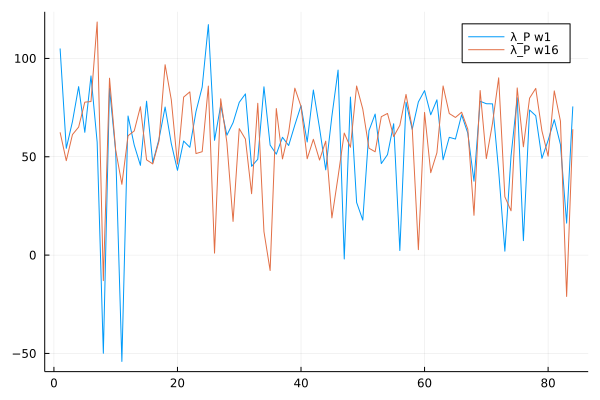

Price in w1: 4958.3600000000015
Price in w16: 4922.97


In [32]:
# visualization of Power purchased from bilateral contracts
x1 = Vector{Float64}()  
for t in T
    append!(x1, value.(λ_P[t,"w1"]))
end
PB1 = sum(value.(λ_P[t,"w1"]) for t in T)

x2 = Vector{Float64}()  
for t in T
    append!(x2, value.(λ_P[t,"w16"]))
end
PB2 = sum(value.(λ_P[t,"w16"]) for t in T)

p = plot(t_length,x1, label="λ_P w1")
display(plot!(t_length, x2, label="λ_P w16"))

#display(plot(Array{Int}(1:length(x1)),x1, label="pool price w1"))
#display(plot(Array{Int}(1:length(x2)),x2, label="pool price w10"))
println("Price in w1: ", PB1)
println("Price in w16: ", PB2)
#savefig("Price_in_w1_w16")

In [33]:
#prices per scenario
for w in W_PP    
    for week in WEEK        
        for b in Bt[week]
            #println(w," ", week)
        for t in week_to_hour[week]
            #print(b," ; λ_B = ", value(λ_B[week, t, w, b]))
            #println(" ; λ_P = ", value(λ_P[t,w]))
        end
        end
        #println()
    end
end

In [34]:
for w in W_PP    
    #println()
    #print(w, ": ")
    for week in WEEK
        #println()
        for b in Bt[week]
            #print(b, " = ", value(PB[b,w]), " ")
        end
        for t in week_to_hour[week]
            #print("EP", " = ", value(EP[t,w]), " ")
        end
    end
end

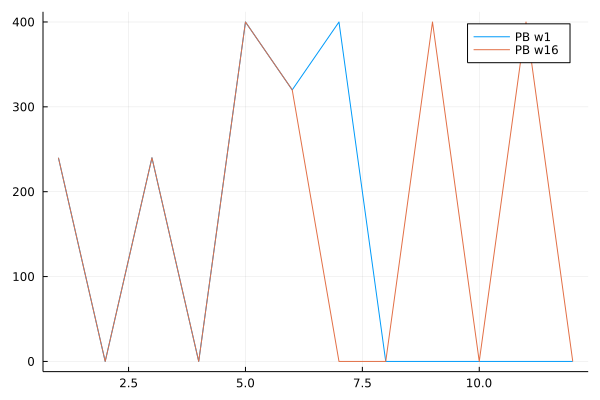

Power purchased from bilateral contracts: 1600.0
Power purchased from bilateral contracts: 2000.0


In [35]:
# visualization of Power purchased from bilateral contracts
x1 = Vector{Float64}()  

for b in B
    append!(x1, value.(PB[b,"w1"]))
end
PB1 = sum(value.(PB[b,"w1"]) for b in B)

x2 = Vector{Float64}()  

for b in B
    append!(x2, value.(PB[b,"w16"]))
end
PB2 = sum(value.(PB[b,"w16"]) for b in B)
p = plot(b_length,x1, label="PB w1")
display(plot!(b_length, x2, label="PB w16"))
#display(plot(Array{Int}(1:length(x1)),x1))
#display(plot(Array{Int}(1:length(x2)),x2))
println("Power purchased from bilateral contracts: ", PB1)
println("Power purchased from bilateral contracts: ", PB2)
#savefig("Bilateral_in_w1_w16")